In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from config import DATA_DIR

In [3]:
from pathlib import Path
import xarray as xr

DATA_DIR = Path("/Users/szelie/data/biofincas")

files = sorted((DATA_DIR / "terra_climate").glob("TerraClimate_*.nc"))
print(len(files), "files found")

ds = xr.open_mfdataset([str(f) for f in files], combine="by_coords")


342 files found


## Climate Trends: Dominican Republic vs. Centro Naturaleza

This analysis compares long-term climate trends in the Dominican Republic (national average) 
with the nearest TerraClimate grid cell to **Centro Naturaleza** (≈ 19.2936°N, -71.2521°W).  

Steps performed:
1. Subset TerraClimate to the Dominican Republic and the specific grid point.
2. Compute annual precipitation (sum), mean temperature, and water balance.
3. Calculate a simplified SPEI (z-score of water balance).
4. Fit linear trends (slopes + p-values) for both the DR average and the grid point.
5. Print trend values (°C/decade, mm/year, SPEI/decade).
6. Plot time series of temperature, precipitation, and SPEI for DR vs Centro Naturaleza.


Central America Trends:
  Temperature: 0.23 °C/decade (p=0.000)
  Precipitation: 0.4 mm/year (p=0.443)
  SPEI: 0.04 /decade (p=0.804)

Dominican Republic Trends:
  Temperature: 0.19 °C/decade (p=0.000)
  Precipitation: -0.5 mm/year (p=0.793)
  SPEI: -0.05 /decade (p=0.752)

Centro Naturaleza (grid point) Trends:
  Temperature: 0.20 °C/decade (p=0.000)
  Precipitation: -1.9 mm/year (p=0.713)
  SPEI: -0.06 /decade (p=0.692)


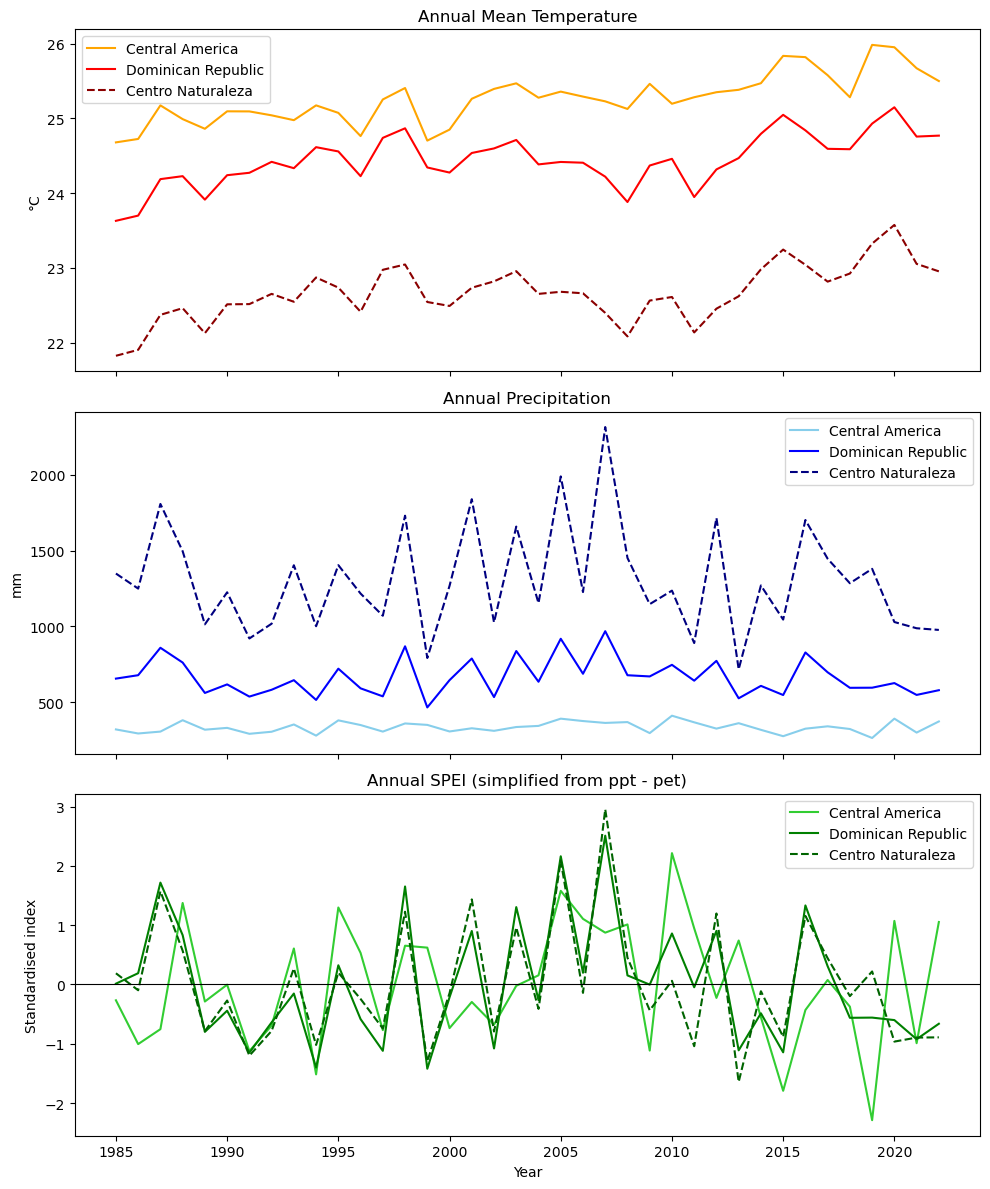

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# --- Define helper functions ---
def aggregate_region(ds_region):
    """Aggregate annual ppt (sum), tmean (mean), and water balance (ppt - pet)."""
    ppt_ann = ds_region["ppt"].groupby("time.year").sum(dim="time")            # mm
    tmean_ann = ((ds_region["tmax"] + ds_region["tmin"]) / 2).groupby("time.year").mean(dim="time")
    wb = (ds_region["ppt"] - ds_region["pet"]).groupby("time.year").sum(dim="time")
    # Collapse to spatial average if regional (has lat/lon)
    if "lat" in wb.dims and "lon" in wb.dims:
        ppt_ann = ppt_ann.mean(dim=["lat","lon"])
        tmean_ann = tmean_ann.mean(dim=["lat","lon"])
        wb = wb.mean(dim=["lat","lon"])
    return ppt_ann, tmean_ann, wb

def zscore(series):
    return (series - series.mean()) / series.std()

def linear_trend(y):
    """OLS linear trend per year. Returns slope per year + p-value."""
    x = np.arange(len(y))
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    return model.params[1], model.pvalues[1]

# --- Coordinates for Centro Naturaleza ---
lat_pt = 19 + 17/60 + 36.9/3600   # ≈ 19.2936
lon_pt = -(71 + 15/60 + 7.6/3600) # ≈ -71.2521

# --- Regional subsets ---
# Central America (Mexico to Panama + Caribbean arc)
ds_ca = ds.sel(lat=slice(23, 7), lon=slice(-92, -60))
# Dominican Republic
ds_dr = ds.sel(lat=slice(20, 17.5), lon=slice(-72, -68))
# Centro Naturaleza single pixel
ds_cn = ds.sel(lat=lat_pt, lon=lon_pt, method="nearest")

# --- Aggregates ---
ppt_ca, tmean_ca, wb_ca = aggregate_region(ds_ca)
ppt_dr, tmean_dr, wb_dr = aggregate_region(ds_dr)
ppt_cn, tmean_cn, wb_cn = aggregate_region(ds_cn)

# --- Simplified SPEI (z-score of wb) ---
spei_ca = zscore(wb_ca)
spei_dr = zscore(wb_dr)
spei_cn = zscore(wb_cn)

# --- Trends ---
trend_t_ca, p_t_ca = linear_trend(tmean_ca.values)
trend_ppt_ca, p_ppt_ca = linear_trend(ppt_ca.values)
trend_spei_ca, p_spei_ca = linear_trend(spei_ca.values)

trend_t_dr, p_t_dr = linear_trend(tmean_dr.values)
trend_ppt_dr, p_ppt_dr = linear_trend(ppt_dr.values)
trend_spei_dr, p_spei_dr = linear_trend(spei_dr.values)

trend_t_cn, p_t_cn = linear_trend(tmean_cn.values)
trend_ppt_cn, p_ppt_cn = linear_trend(ppt_cn.values)
trend_spei_cn, p_spei_cn = linear_trend(spei_cn.values)

# --- Print all results ---
print("\nCentral America Trends:")
print(f"  Temperature: {trend_t_ca*10:.2f} °C/decade (p={p_t_ca:.3f})")
print(f"  Precipitation: {trend_ppt_ca:.1f} mm/year (p={p_ppt_ca:.3f})")
print(f"  SPEI: {trend_spei_ca*10:.2f} /decade (p={p_spei_ca:.3f})")

print("\nDominican Republic Trends:")
print(f"  Temperature: {trend_t_dr*10:.2f} °C/decade (p={p_t_dr:.3f})")
print(f"  Precipitation: {trend_ppt_dr:.1f} mm/year (p={p_ppt_dr:.3f})")
print(f"  SPEI: {trend_spei_dr*10:.2f} /decade (p={p_spei_dr:.3f})")

print("\nCentro Naturaleza (grid point) Trends:")
print(f"  Temperature: {trend_t_cn*10:.2f} °C/decade (p={p_t_cn:.3f})")
print(f"  Precipitation: {trend_ppt_cn:.1f} mm/year (p={p_ppt_cn:.3f})")
print(f"  SPEI: {trend_spei_cn*10:.2f} /decade (p={p_spei_cn:.3f})")

# --- Plots ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Temperature
axes[0].plot(tmean_ca["year"], tmean_ca, label="Central America", color="orange")
axes[0].plot(tmean_dr["year"], tmean_dr, label="Dominican Republic", color="red")
axes[0].plot(tmean_cn["year"], tmean_cn, label="Centro Naturaleza", color="darkred", linestyle="--")
axes[0].set_ylabel("°C")
axes[0].set_title("Annual Mean Temperature")
axes[0].legend()

# Precipitation
axes[1].plot(ppt_ca["year"], ppt_ca, label="Central America", color="skyblue")
axes[1].plot(ppt_dr["year"], ppt_dr, label="Dominican Republic", color="blue")
axes[1].plot(ppt_cn["year"], ppt_cn, label="Centro Naturaleza", color="navy", linestyle="--")
axes[1].set_ylabel("mm")
axes[1].set_title("Annual Precipitation")
axes[1].legend()

# SPEI
axes[2].plot(spei_ca["year"], spei_ca, label="Central America", color="limegreen")
axes[2].plot(spei_dr["year"], spei_dr, label="Dominican Republic", color="green")
axes[2].plot(spei_cn["year"], spei_cn, label="Centro Naturaleza", color="darkgreen", linestyle="--")
axes[2].axhline(0, color="black", lw=0.8)
axes[2].set_ylabel("Standardised index")
axes[2].set_title("Annual SPEI (simplified from ppt - pet)")
axes[2].legend()

plt.xlabel("Year")
plt.tight_layout()
plt.show()


## Results Summary

### Dominican Republic (national average)
- **Temperature** has increased significantly, at **~0.19 °C per decade** (p < 0.001).  
- **Precipitation** shows a slight negative trend (**–0.5 mm/year**), but this is **not statistically significant**.  
- **SPEI** (simplified drought index) also trends slightly negative (**–0.05 per decade**), suggesting mild drying, but again **not significant**.

### Centro Naturaleza (nearest grid cell)
- **Temperature** increase is very similar, at **~0.20 °C per decade** (p < 0.001), confirming the strong warming signal locally.  
- **Precipitation** declines a bit faster (**–1.9 mm/year**), but with **low statistical significance**.  
- **SPEI** trends slightly negative (**–0.06 per decade**), consistent with national drying patterns, though not significant.

### Comparison to Global Averages
The observed warming of **~0.20 °C per decade** in the Dominican Republic is slightly **above the global average**, which has been around **0.18 °C per decade since the late 20th century**.  
This indicates that the Dominican Republic is warming at a pace comparable to, or a bit faster than, the global mean — consistent with regional projections for the Caribbean, where land areas tend to heat more rapidly than the oceans.

### Interpretation
Both the national average and the Centro Naturaleza grid cell show a **robust warming signal** of around **+0.2 °C per decade**, in line with broader Caribbean climate trends.  
Changes in **precipitation** and **drought index (SPEI)** are small relative to natural variability and **not statistically significant** over the study period.


# Climate Trends in the Dominican Republic

This script computes and visualises long-term climate trends for the **Dominican Republic**, with a focus on a specific reference point (Centro Naturaleza, marked with an "x").  

## Workflow
1. **Data extraction**
   - Subsets gridded climate data (`ppt`, `tmax`, `tmin`, `pet`) to the Dominican Republic.  
   - Defines a reference location (`lat=19.2936`, `lon=-71.2521`) for comparison.  

2. **Annual aggregation**
   - **Precipitation (`ppt_ann`)**: annual totals (mm/year).  
   - **Temperature (`tmean_ann`)**: annual mean of daily averages.  
   - **Water balance (`wb_ann`)**: annual sum of precipitation minus potential evapotranspiration.  

3. **SPEI (simplified)**
   - Computes a z-score of the water balance to approximate drought/wetness conditions.  

4. **Trend estimation**
   - Uses `xarray.polyfit` to fit linear trends in time.  
   - Reported as:  
     - **Temperature**: °C per decade  
     - **Precipitation**: mm per year  
     - **SPEI**: standardised units per decade  

5. **Mapping results**
   - **Temperature trends**: shown in **red tones** (only positive values).  
   - **Precipitation trends**: shown with a diverging **BrBG** colormap.  
   - **SPEI trends**: shown with a diverging **RdBu** colormap.  
   - The black **x** marks Centro Naturaleza.  

## Example Results
- **Temperature**: Consistent warming signal (~0.2 °C per decade).  
- **Precipitation**: Trends are weaker and less consistent (mm/year).  
- **SPEI**: Indicates long-term shifts in water balance, with negative trends implying drying.  

## Interpretation
- The maps highlight regional patterns across the Dominican Republic.  
- The reference point allows comparison between local and national-scale climate evolution.  
- While warming is statistically significant, precipitation and SPEI trends are noisier and less robust.  


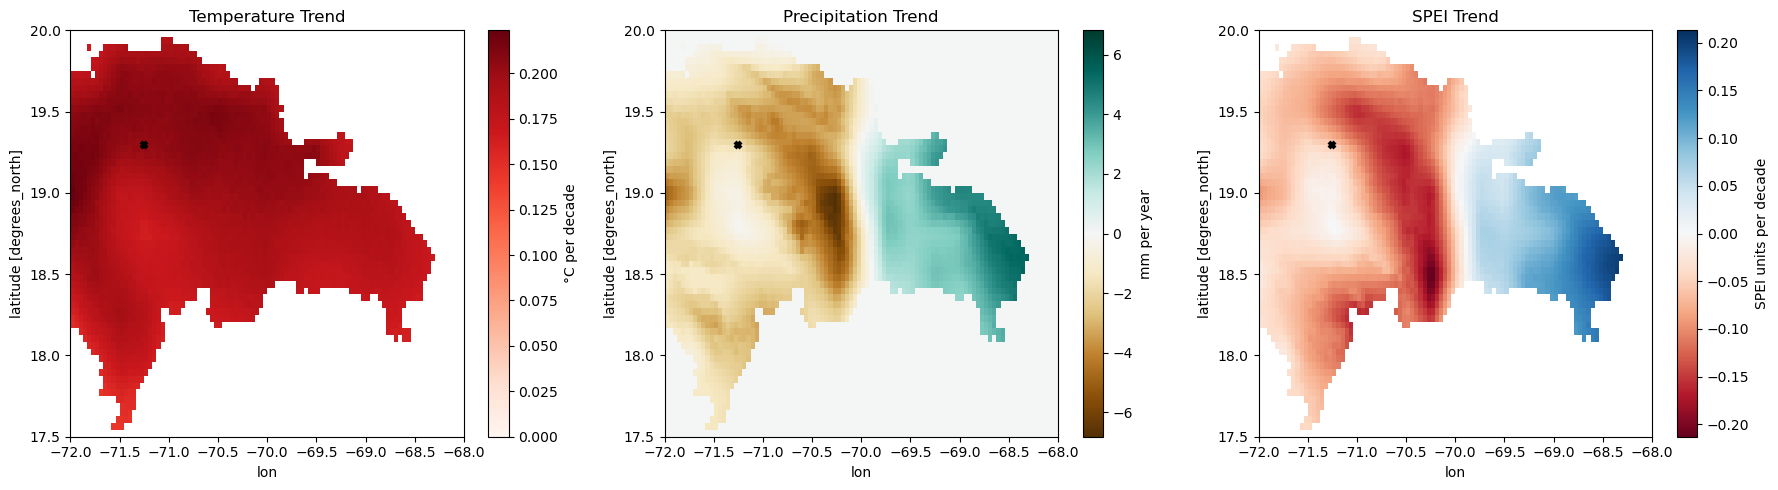

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define point coordinates for Centro Naturaleza ---
lat_pt = 19 + 17/60 + 36.9/3600   # ≈ 19.2936
lon_pt = -(71 + 15/60 + 7.6/3600) # ≈ -71.2521

# --- Subset DR ---
ds_dr = ds.sel(lat=slice(20, 17.5), lon=slice(-72, -68))

# --- Annual aggregates ---
ppt_ann = ds_dr["ppt"].groupby("time.year").sum("time")
tmean_ann = ((ds_dr["tmax"] + ds_dr["tmin"]) / 2).groupby("time.year").mean("time")
wb_ann = (ds_dr["ppt"] - ds_dr["pet"]).groupby("time.year").sum("time")

# --- SPEI (z-score per cell) ---
spei = (wb_ann - wb_ann.mean("year")) / wb_ann.std("year")

# --- Use xarray polyfit: slope = polyfit coeff for year ---
trend_t = tmean_ann.polyfit(dim="year", deg=1)["polyfit_coefficients"].sel(degree=1) * 10   # °C/decade
trend_ppt = ppt_ann.polyfit(dim="year", deg=1)["polyfit_coefficients"].sel(degree=1)       # mm/year
trend_spei = spei.polyfit(dim="year", deg=1)["polyfit_coefficients"].sel(degree=1) * 10    # z/decade

# --- Define symmetric vmin/vmax for diverging colormaps ---
def symmetric_range(da):
    vmax = float(np.nanmax(np.abs(da.values)))
    return -vmax, vmax

vmin_ppt, vmax_ppt = symmetric_range(trend_ppt)
vmin_spei, vmax_spei = symmetric_range(trend_spei)

# --- Plot maps ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Temperature (reds only)
trend_t.plot(
    ax=axs[0], cmap="Reds",
    vmin=0, vmax=float(trend_t.max()),
    cbar_kwargs={"label": "°C per decade"}
)
axs[0].plot(lon_pt, lat_pt, marker="x", markersize=5, color="black", mew=3)
axs[0].set_title("Temperature Trend")

# Precipitation
trend_ppt.plot(
    ax=axs[1], cmap="BrBG", vmin=vmin_ppt, vmax=vmax_ppt,
    cbar_kwargs={"label": "mm per year"}
)
axs[1].plot(lon_pt, lat_pt, marker="x", markersize=5, color="black", mew=3)
axs[1].set_title("Precipitation Trend")

# SPEI
trend_spei.plot(
    ax=axs[2], cmap="RdBu", vmin=vmin_spei, vmax=vmax_spei,
    cbar_kwargs={"label": "SPEI units per decade"}
)
axs[2].plot(lon_pt, lat_pt, marker="x", markersize=5, color="black", mew=3)
axs[2].set_title("SPEI Trend")

plt.tight_layout()
plt.show()


# Microclimate Data Preprocessing

This script loads and cleans **microclimate station data** from Excel files (`2020–2023`) stored in yearly workbooks.  

## Workflow
1. **Input**
   - Excel files stored in `DATA_DIR/microclimate/`, named `2020.xlsx`, `2021.xlsx`, etc.  
   - Each file may contain multiple sheets.  

2. **Sheet parsing**
   - Skips the first row (metadata).  
   - Strips leading/trailing spaces from column names.  
   - Dynamically detects the datetime column:
     - First looks for `"Date Time"`.  
     - If not found, falls back to the first column.  
   - Detects temperature column:
     - If the known logger name (`"Temp, °C (LGR S/N: 20617834, ...)"`) exists, uses it.  
     - Otherwise, falls back to the third column.  

3. **Data cleaning**
   - Keeps only three columns:  
     - `datetime` (converted to pandas `datetime`, `dayfirst=True`)  
     - `temp_C` (°C)  
     - `precip_mm` (mm)  
   - Extracts `year` and `month` for convenience.  
   - Drops rows where `datetime`, `temp_C`, and `precip_mm` are all missing.  

4. **Output**
   - Concatenates all sheets and years into one dataframe: `micro_df`.  
   - Example structure:  

     | datetime            | temp_C | precip_mm | year | month |
     |---------------------|--------|-----------|------|-------|
     | 2020-01-01 00:00:00 |  24.3  |    0.0    | 2020 |   1   |
     | 2020-01-01 01:00:00 |  24.1  |    0.0    | 2020 |   1   |
     | 2020-01-01 02:00:00 |  23.9  |    0.0    | 2020 |   1   |

## Notes
- Script is robust to sheet variations — it prints a warning if a sheet cannot be parsed.  
- Designed for flexible logger naming conventions across years.  
- Produces a **long-format dataframe** suitable for aggregation (daily/monthly summaries, climatology, etc.).  

## Example usage
Run the script and inspect the first rows:  

```python
print(micro_df.head())


In [11]:
import pandas as pd
import os

# Path to your Excel files
base_path = DATA_DIR / "microclimate"
years = range(2020, 2024)

all_dfs = []

for year in years:
    file_path = os.path.join(base_path, f"{year}.xlsx")
    xl = pd.ExcelFile(file_path)
    for sheet in xl.sheet_names:
        try:
            df = xl.parse(sheet, skiprows=1)
            df = df.rename(columns=lambda x: str(x).strip())  # remove leading/trailing spaces

            # Flexible detection of datetime column
            datetime_col = next((col for col in df.columns if "Date Time" in col), df.columns[0])

            # Temperature column: exact match or fallback to 3rd column
            temp_col = (
                "Temp, °C (LGR S/N: 20617834, SEN S/N: 20617834, LBL: Temperatura)"
                if "Temp, °C (LGR S/N: 20617834, SEN S/N: 20617834, LBL: Temperatura)" in df.columns
                else df.columns[2]
            )

            df_clean = df[[datetime_col, temp_col, "mm"]].copy()
            df_clean.columns = ["datetime", "temp_C", "precip_mm"]

            df_clean["datetime"] = pd.to_datetime(df_clean["datetime"], errors="coerce", dayfirst=True)
            df_clean["year"] = df_clean["datetime"].dt.year
            df_clean["month"] = df_clean["datetime"].dt.month

            all_dfs.append(df_clean)
        except Exception as e:
            print(f"Skipping sheet {sheet} in {year}: {e}")

# Combine all years
micro_df = pd.concat(all_dfs, ignore_index=True)

# Drop rows with missing datetime or all NaNs
micro_df = micro_df.dropna(subset=["datetime", "temp_C", "precip_mm"], how="all")

# Optional: display head
print(micro_df.head())


Skipping sheet Mayo in 2021: "['mm'] not in index"
Skipping sheet junio in 2021: "['mm'] not in index"
Skipping sheet Agosto in 2021: "['mm'] not in index"
Skipping sheet Septiembre in 2021: "['mm'] not in index"
Skipping sheet Octubre  in 2021: "['mm'] not in index"
Skipping sheet Noviembre  in 2021: "['mm'] not in index"
Skipping sheet Diciembre  in 2021: "['mm'] not in index"
Skipping sheet Mayo in 2022: "['mm'] not in index"
Skipping sheet junio in 2022: "['mm'] not in index"
Skipping sheet Julio in 2022: "['mm'] not in index"
Skipping sheet Agosto in 2022: "['mm'] not in index"
Skipping sheet Septiembre in 2022: "['mm'] not in index"
Skipping sheet Octubre  in 2022: "['mm'] not in index"
Skipping sheet Noviembre  in 2022: "['mm'] not in index"
Skipping sheet Diciembre  in 2022: index 0 is out of bounds for axis 0 with size 0
Skipping sheet Enero in 2023: index 0 is out of bounds for axis 0 with size 0
Skipping sheet Febrero in 2023: index 0 is out of bounds for axis 0 with size 0


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_2263/392473862.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean["datetime"] = pd.to_datetime(df_clean["datetime"], errors="coerce", dayfirst=True)


             datetime  temp_C  precip_mm    year  month
0 2020-01-01 00:00:00  19.092        0.0  2020.0    1.0
1 2020-01-01 00:30:00  18.521        0.0  2020.0    1.0
2 2020-01-01 01:00:00  18.426        0.0  2020.0    1.0
3 2020-01-01 01:30:00  18.045        0.0  2020.0    1.0
4 2020-01-01 02:00:00  17.760        0.0  2020.0    1.0


# Comparing Microclimate Station Data with TerraClimate

This script processes **local station data** from Centro Naturaleza and compares it against gridded **TerraClimate reanalysis** for 2020–2023.  

## Workflow

### 1. Clean cumulative precipitation
- The raw station logger records **cumulative rainfall**, resetting to zero after each event.  
- A custom function `clean_cumulative_precip()` converts this into **incremental daily rainfall** by detecting resets and only keeping positive increments.  

### 2. Aggregate microclimate to monthly
- The cleaned microclimate dataframe is resampled:  
  - `micro_temp` = mean monthly temperature (°C)  
  - `micro_precip` = total monthly precipitation (mm)  

### 3. Extract TerraClimate data
- The grid cell nearest to Centro Naturaleza (`lat ≈ 19.2936`, `lon ≈ -71.2521`) is extracted from TerraClimate.  
- Monthly mean temperature = (`tmax + tmin`) / 2.  
- Monthly precipitation = `ppt`.  
- Restricted to 2020–2023 for comparison with the station record.  

### 4. Merge datasets
- Both datasets are merged on the monthly time index (`month`).  
- Resulting dataframe:  

| month      | micro_temp | micro_precip | terra_tmean | terra_ppt |
|------------|------------|--------------|-------------|-----------|
| 2020-01-01 |   23.5     |     48.0     |    23.8     |   52.3    |
| 2020-02-01 |   24.1     |     12.0     |    24.4     |   10.7    |
| ...        |    ...     |     ...      |     ...     |    ...    |

### 5. Plotting
- **Temperature subplot**  
  - Station monthly mean (`micro_temp`) vs TerraClimate (`terra_tmean`)  
- **Precipitation subplot**  
  - Station monthly sum (`micro_precip`) vs TerraClimate (`terra_ppt`)  
- Shared x-axis for time (2020–2023).  

### 6. Correlation check
- Quick Pearson correlation is printed for both variables:  



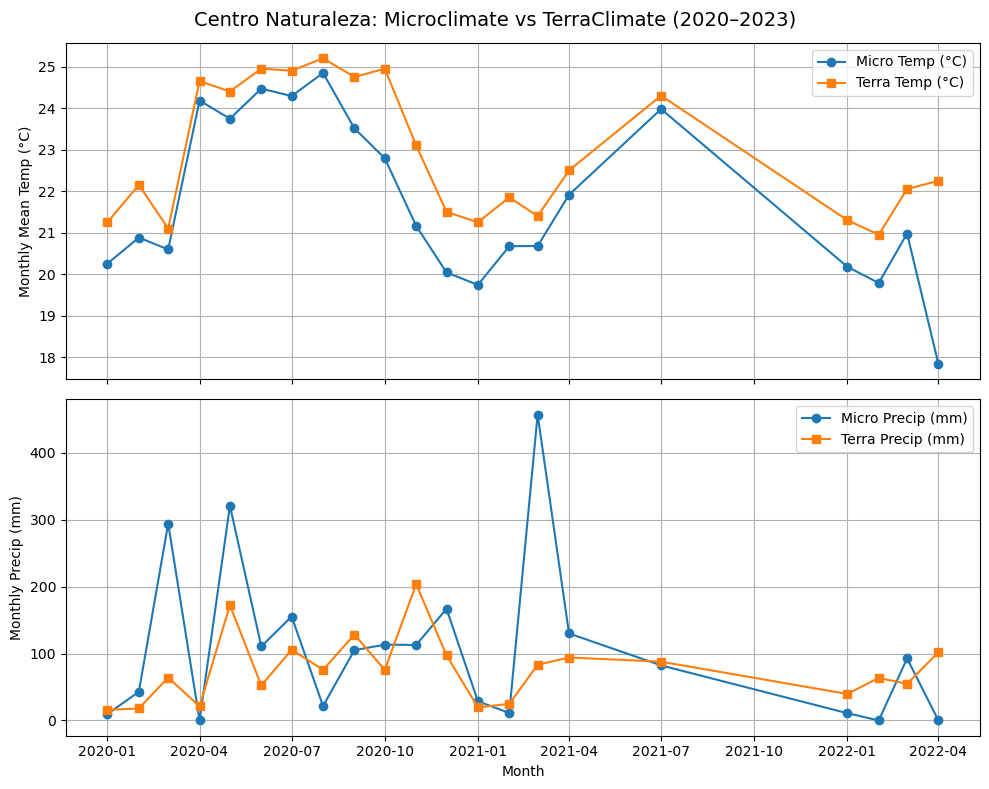

Temperature correlation: 0.8954443991707405
Precipitation correlation: 0.42968259590813224


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Clean cumulative precipitation ---
def clean_cumulative_precip(raw_series):
    raw = raw_series.copy().reset_index(drop=True)
    clean = []
    last_valid = None
    for val in raw:
        if val == 0:
            last_valid = None
            clean.append(0)
        elif last_valid is None:
            last_valid = val
            clean.append(0)
        else:
            diff = val - last_valid
            clean.append(diff if diff > 0 else 0)
            last_valid = val
    return pd.Series(clean, index=raw_series.index)

micro_df = micro_df.sort_values("datetime").copy()
micro_df["precip_daily"] = clean_cumulative_precip(micro_df["precip_mm"])
micro_df = micro_df.dropna(subset=["precip_daily"])

# --- 2. Aggregate microclimate to monthly ---
micro_df["month"] = micro_df["datetime"].dt.to_period("M")
micro_monthly = micro_df.groupby("month").agg({
    "temp_C": "mean",
    "precip_daily": "sum"
}).rename(columns={"temp_C": "micro_temp", "precip_daily": "micro_precip"}).reset_index()
micro_monthly["month"] = micro_monthly["month"].dt.to_timestamp()

# --- 3. Extract TerraClimate at Centro Naturaleza grid point ---
lat_pt = 19 + 17/60 + 36.9/3600   # ≈ 19.2936
lon_pt = -(71 + 15/60 + 7.6/3600) # ≈ -71.2521
ds_point = ds.sel(lat=lat_pt, lon=lon_pt, method="nearest")

terra_monthly_df = pd.DataFrame({
    "month": pd.to_datetime(ds_point.time.values),
    "terra_tmean": ((ds_point["tmax"] + ds_point["tmin"]) / 2).values,
    "terra_ppt": ds_point["ppt"].values
})

# Restrict to overlapping period (2020–2023)
terra_monthly_df = terra_monthly_df.set_index("month").loc["2020":"2023"].reset_index()

# --- 4. Merge station & TerraClimate ---
compare_df = pd.merge(micro_monthly, terra_monthly_df, on="month", how="inner")

# --- 5. Plot ---
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Temperature
ax[0].plot(compare_df["month"], compare_df["micro_temp"], "o-", label="Micro Temp (°C)")
ax[0].plot(compare_df["month"], compare_df["terra_tmean"], "s-", label="Terra Temp (°C)")
ax[0].set_ylabel("Monthly Mean Temp (°C)")
ax[0].legend()
ax[0].grid(True)

# Precipitation
ax[1].plot(compare_df["month"], compare_df["micro_precip"], "o-", label="Micro Precip (mm)")
ax[1].plot(compare_df["month"], compare_df["terra_ppt"], "s-", label="Terra Precip (mm)")
ax[1].set_ylabel("Monthly Precip (mm)")
ax[1].legend()
ax[1].grid(True)

plt.xlabel("Month")
plt.suptitle("Centro Naturaleza: Microclimate vs TerraClimate (2020–2023)", fontsize=14)
plt.tight_layout()
plt.show()

# Optional: quick correlation check
print("Temperature correlation:", compare_df["micro_temp"].corr(compare_df["terra_tmean"]))
print("Precipitation correlation:", compare_df["micro_precip"].corr(compare_df["terra_ppt"]))
